In [ ]:
# Computational biology FFR110 - 2024
# Assignment 2 - Problem 3: Synchronisation
# Fredrik Sitje, Felix Waldschock

# Kuramoto Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import scienceplots
plt.style.use('science')
import scipy 


In [ ]:
# Parameters
gamma = 0.1

Kvalues = []                # Coupling strength -> overwrite later
Nvalues = [20, 100, 300, 1000]    # Number of oscillators in the system

dt = 0.01
Tend = 10
TendSteps = int(Tend/dt)

In [ ]:
def g(w):
    global gamma
    return (gamma / np.pi) / (w**2 + gamma**2)

# Initialize the frequencies of the oscillators with a Cauchy distribution
def initFrequencies(N, gamma):
    samples = scipy.stats.cauchy.rvs(loc=0, scale=gamma, size=N)
    return samples

# Inintialize the phase of the oscillators between -pi/2 and pi/2
def initializePhases(N):
    phases = np.random.uniform(-np.pi/2, np.pi/2, N)
    return phases



criticalK = 2/(g(0)*np.pi)
print(f'Critical K: {criticalK}')
Kvalues.append(criticalK * 0.05)
Kvalues.append(criticalK * 1.01)
Kvalues.append(criticalK * 1.1)
Kvalues.append(criticalK * 4)


# Check if the cauchy distribution works as expected


In [ ]:
w1 = initFrequencies(10000, gamma=0.1)
w2 = initFrequencies(10000, gamma=0.5)
w3 = initFrequencies(10000, gamma=1)

# trow all values out that are larger than 4 or smaller than -4
w1 = w1[(w1 < 4) & (w1 > -4)]
w2 = w2[(w2 < 4) & (w2 > -4)]
w3 = w3[(w3 < 4) & (w3 > -4)]

# show a probability distribution of the natural frequencies
plt.figure(figsize=(8,6))
plt.hist(w1, bins= 1000, alpha=0.5, label='gamma=0.1', density=True)
plt.hist(w2, bins=1000, alpha=0.5, label='gamma=0.5', density=True)
plt.hist(w3, bins=1000, alpha=0.5, label='gamma=1', density=True)
plt.xlim([-4,4])

plt.legend()
plt.xlabel('Natural frequency')
plt.ylabel('Count')
plt.title('Natural frequency distribution')
plt.grid()

# safe fig as .eps
plt.savefig('1-3_natural_frequency_distribution.eps', format='eps')
plt.show()

$\frac{d\theta_i }{dt} = \omega_i + \frac{K}{N} * \sum_{j=1}^{N} sin(\theta_j - \theta_i)$

$d\theta_i = {dt}(\omega_i + \frac{K}{N} * \sum_{j=1}^{N} sin(\theta_j - \theta_i))$


In [ ]:
# Define the Kuramoto model
def runKuramoto(N, K):
    global dt
    global gamma
    oscillators = initializePhases(N)
    frequencies = initFrequencies(N, gamma=gamma)
    inititalPhase = np.array(oscillators)
    oscillators_history = np.zeros((TendSteps+1, N))
    oscillators_history[0] = inititalPhase

    K_over_N = K / N  # precompute constant

    for t in range(TendSteps):
        for i, theta_i in enumerate(oscillators):
            sum_sin = np.sum(np.sin(oscillators - theta_i))
            oscillators[i] += dt * (frequencies[i] + K_over_N * sum_sin)

        # update the history
        oscillators_history[t+1] = oscillators

    return oscillators_history, inititalPhase


In [ ]:
# Class to store the results
class Result:
    N = None
    K = None
    oscillationHistory = None
    orderParameter = None
    initialPhase = None

    def __init__(self, N, K, oscillation_history, initial_phase):
        self.N = N
        self.K = K
        self.oscillationHistory = oscillation_history
        self.initialPhase = initial_phase


In [55]:
# simulations = np.zeros((len(Nvalues), len(Kvalues), TendSteps, max(Nvalues)))
simulationsResults = []

# run the simulation for different values of N and K
for n in trange(len(Nvalues)):
    for k in range(len(Kvalues)):
        oscillators_history, initial_phase = runKuramoto(Nvalues[n], Kvalues[k])
        # simulations[n, k] = oscillators_history
        # create new Result
        result = Result(Nvalues[n], Kvalues[k], oscillators_history, initial_phase)
        simulationsResults.append(result)




100%|██████████| 4/4 [00:38<00:00,  9.60s/it]


# now determine the order parameter from the simulation

$r(t) = \frac{1}{N} | \sum_{j=1}^{N} cos(\theta_j(t)) + j * sin(\theta_j(t))|$


In [56]:
def order_parameter(oscillators):
    r = []
    # map the oscillators in between -pi and pi
    #oscillators = (oscillators) % (2 * np.pi)
    for t in range(len(oscillators)):
        r.append(np.abs(np.mean(np.exp(1j * oscillators[t,:]))))
    return r


In [57]:
for result in simulationsResults:
    result.orderParameter = order_parameter(result.oscillationHistory)

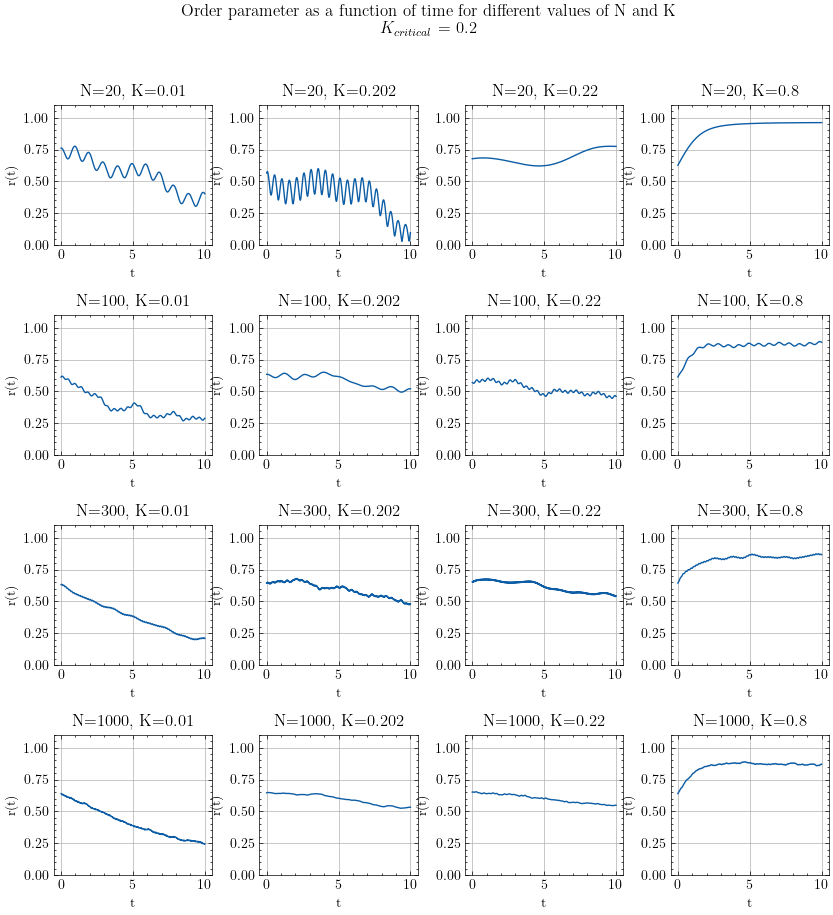

In [58]:
fig, ax = plt.subplots(len(Nvalues), len(Kvalues), figsize=(10,10))
timeVector = np.linspace(0, Tend, TendSteps+1)
for i in range(len(Nvalues)):
    for j in range(len(Kvalues)):
        
        ax[i, j].plot(timeVector, simulationsResults[i*len(Kvalues) + j].orderParameter)
        ax[i, j].set_xlabel('t')
        ax[i, j].set_ylabel('r(t)')
        ax[i, j].grid()
        ax[i, j].set_title(f'N={Nvalues[i]}, K={round(Kvalues[j], 4)}')
        ax[i, j].set_ylim(0, 1.1)

        plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.suptitle('Order parameter as a function of time for different values of N and K\n $K_{critical}$ = '+ f'{round(criticalK, 6)}')

fig.savefig('1-3_order_parameter.eps', format='eps', dpi=1200)
plt.show()



We find that in the beginning, as the oscialltors are inititlized between $\pi/2$ and $-\pi/2$ that the order parameter is way above 0. For it to be around 0, at least for the large numbers of oscialltors, the initialization should be done over an range of $2*\pi$.
In the first column, the coupling is far below $K_c$ and due to the fact that the frequencies of the oscillators vary the coupling fades away with time.
In the second column the dynamics for a coupling that is 5% above $K_c$ is visualised. We find that the order parameters does decrease over time, for systems with fewer oscillators, but for a large number of oscillators decreases less or less fast.
In the final column, a system with a coupling of $4*K_c$ is visualies. One can clearly find, that the order parameter quickly increases and stays, except from some fluctuation, in this high level. Therefore one can say, that the oscillators are synchronised.


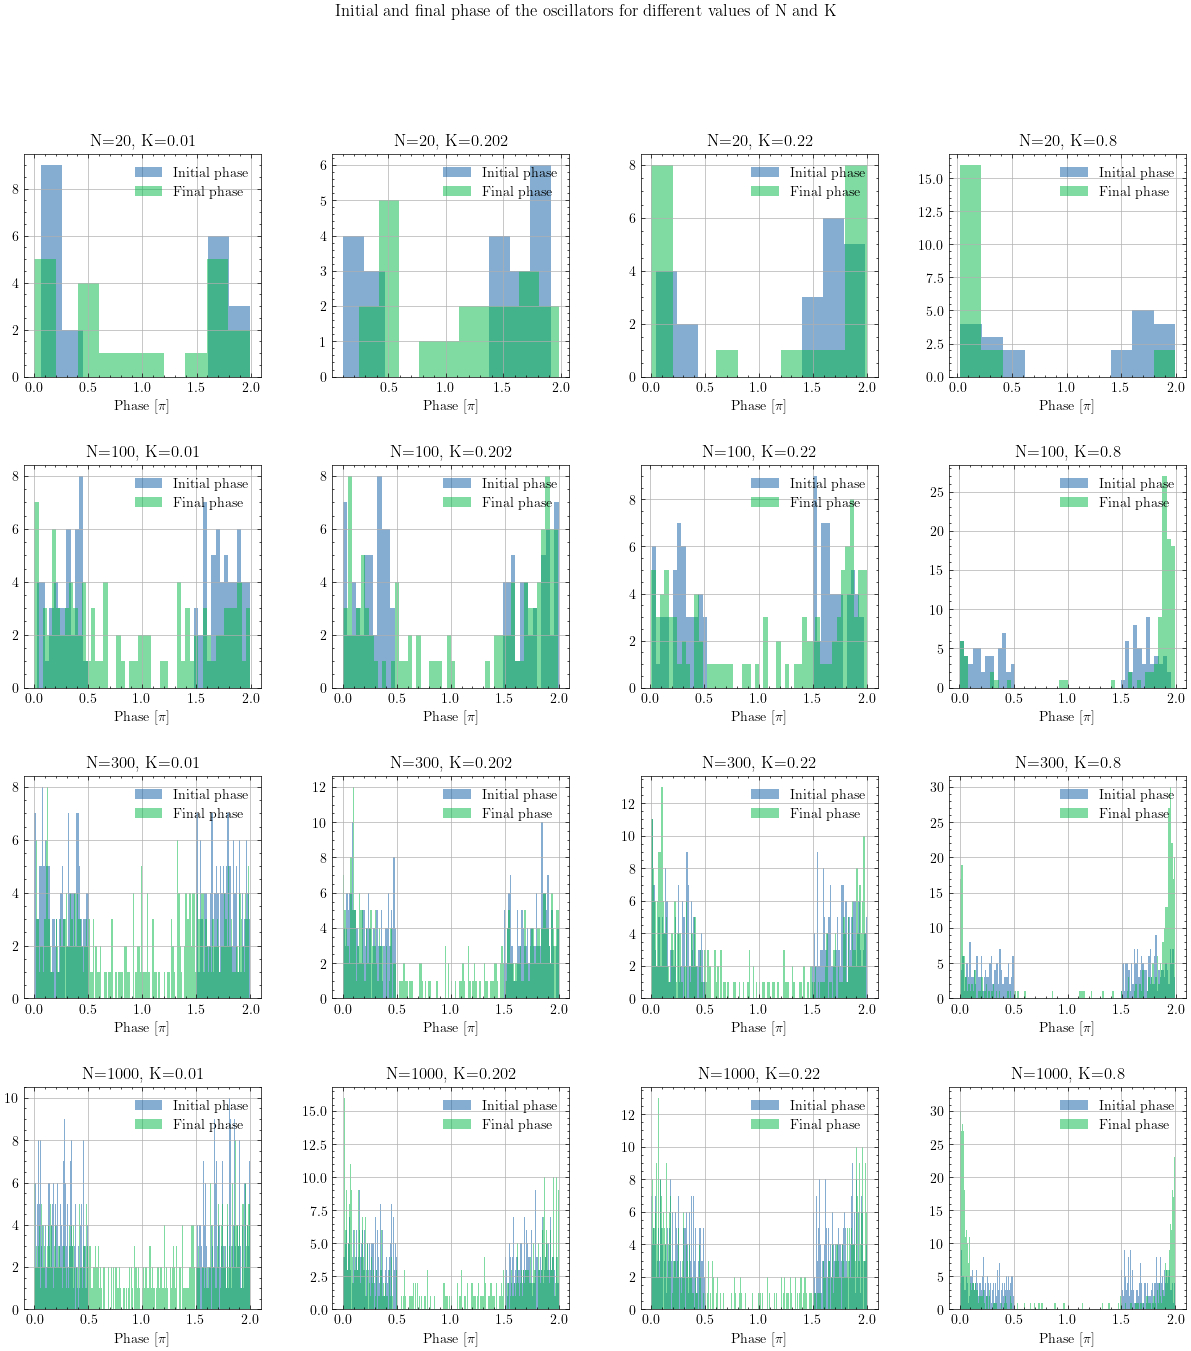

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [59]:
# plot an other subplot with the initial phase and final phase of the oscillators
fig, ax = plt.subplots(len(Nvalues), len(Kvalues), figsize=(15,15))
for i in range(len(Nvalues)):
    for j in range(len(Kvalues)):
        result = simulationsResults[i*len(Kvalues) + j]
        initial_phase = np.mod(result.oscillationHistory[0], 2*np.pi)
        final_phase = np.mod(result.oscillationHistory[-1], 2*np.pi)
        # ax[i, j].plot(initial_phase / np.pi, label='Initial phase')
        # ax[i, j].plot(final_phase / np.pi, label='Final phase')
        ax[i, j].hist(initial_phase / np.pi, bins=int(Nvalues[i]/2), alpha=0.5, label='Initial phase')
        ax[i, j].hist(final_phase / np.pi, bins=int(Nvalues[i]/2), alpha=0.5, label='Final phase')
        ax[i, j].set_xlabel('Phase $[\pi]$')    
        # ax[i, j].set_xlabel('Oscillator index')
        # ax[i, j].set_ylabel('Phase $[\pi]$' )
        ax[i, j].grid()
        ax[i, j].set_title(f'N={Nvalues[i]}, K={round(Kvalues[j], 4)}')
        ax[i, j].legend(loc='upper right')
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.suptitle('Initial and final phase of the oscillators for different values of N and K')
plt.show()

# save figure as eps
fig.savefig('initial_final_phase.eps', format='eps', dpi=1200)

In [60]:
# # do the same simulation for a fixed N and a linspace of K from 0 to 4 with 200 points
# Nvalues1 = [1000]
# K0 = 0
# KStop = 2 * criticalK
# Kvalues1 = np.linspace(K0, KStop, 20)

# # simulations = np.zeros((len(Nvalues), len(Kvalues), TendSteps, max(Nvalues)))
# simulationsResults2 = []

# # run the simulation for different values of N and K
# for n in range(len(Nvalues1)):
#     for k in trange(len(Kvalues1)):
#         oscillators_history, initial_phase = runKuramoto(Nvalues1[n], Kvalues1[k])
#         # simulations[n, k] = oscillators_history
#         # create new Result
#         result = Result(Nvalues1[n], Kvalues1[k], oscillators_history, initial_phase)
#         simulationsResults2.append(result)

# # calculate the order parameter for each simulation
# for result in simulationsResults2:
#     result.orderParameter = order_parameter(result.oscillationHistory)

# order_parameterS = [result.orderParameter[-1] for result in simulationsResults2]



In [61]:

# plt.figure(figsize=(10,5))
# plt.plot(Kvalues1, order_parameterS)
# plt.xlabel('K')
# plt.ylabel('Order parameter $r$')
# plt.title('Order parameter as a function of K for fixed N = '+ f'{Nvalues[0]}')
# plt.grid()
# plt.axvline(x=criticalK, color='r', linestyle='--', label='$K_{critical}$')
# plt.show()

# # save figure as eps
# plt.savefig('order_parameter_fixed_N.eps', format='eps', dpi=1200)
